## Τα Στοιχεία μου
ΤΥΠΑΛΔΟΣ-ΠΑΥΛΟΣ ΑΠΟΣΤΟΛΑΤΟΣ 1115201800009



# Initialisation

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import nltk
import re
from gensim.models import Word2Vec
from sklearn.metrics import f1_score,recall_score,precision_score,confusion_matrix,classification_report
from gensim.parsing.preprocessing import remove_stopwords
import urllib.request
from scipy import spatial
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.nn.functional as F
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/AI2/" #update this
#path = "C:/Users/Pavlos/Desktop/AI2/" #update this
import sys, os
from statistics import mean
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from scipy import interp
from itertools import cycle

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv(path + "vaccine_train_set.csv",index_col=0)
validation_set = pd.read_csv(path + "vaccine_validation_set.csv",index_col=0) # and this. only those 2 needed to run your own test csv
print(train_df)
print(validation_set)
# print(validation_set.iat[0,0])

                                                   tweet  label
0      Sip N Shop Come thru right now #Marjais #Popul...      0
1      I don't know about you but My family and I wil...      1
2      @MSignorile Immunizations should be mandatory....      2
3      President Obama spoke in favor of vaccination ...      0
4      "@myfoxla: Arizona monitoring hundreds for mea...      0
...                                                  ...    ...
15971  @Salon if u believe the anti-vax nutcases caus...      1
15972  How do you feel about parents who don't #vacci...      0
15973  70 Preschoolers Tested for Measles in Simi Val...      0
15974  Finance Minister: Budget offers room to procur...      0
15975  Are you up to date on vaccines? Take CDC’s vac...      2

[15976 rows x 2 columns]
                                                  tweet  label
0     @user They had a massive surge in with covid d...      1
1     Required vaccines for school: Parents and guar...      0
2     “@KCStar: T

# Προεπεξεργασία δεδομένων
κανω ολες τις λεξεις lowercase ετσι ωστε να μην θεωρουνται διαφορετικες λογω ενος κεφαλαιου αρχικου γραμματος και βγαζω σημεια στιξης

#Σε αντίθεση με την ασκηση 1
δεν εκτελω τις 2 τελευταιες γραμμες γιατι καταργουν χαρακτηριστικα των tweets που συνυπολογιζονται στο κελί 
"Optimisation των λεξεων μας για το Twitter"

γενικα η χρήση αυτου του κελιού είναι up to debate. θεωρητικα θα βοηθήσει το word2vec γιατι θα μετατρέψει το κειμενο με απλες λεξεις για τις οποιες μπόρει να εκπαιδευτεί αλλα θα εμποδίσει το GloVe γιατί του καταργεί την ιδιατερότητα

In [ ]:
train_df['tweet'] = train_df['tweet'].apply(lambda x: x.lower())
# train_df['tweet'] = train_df['tweet'].apply(lambda x: re.sub(r'\W', ' ', x))
# train_df['tweet'] = train_df['tweet'].apply(lambda x:re.sub(r'\s+', ' ', x))

validation_set['tweet'] = validation_set['tweet'].apply(lambda x: x.lower())
# validation_set['tweet'] = validation_set['tweet'].apply(lambda x: re.sub(r'\W', ' ', x))
# validation_set['tweet'] = validation_set['tweet'].apply(lambda x:re.sub(r'\s+', ' ', x))


In [ ]:
train_df = train_df.drop(train_df[train_df.tweet.str.len() < 2].index)
validation_set = validation_set.drop(validation_set[validation_set.tweet.str.len() < 2].index)

## Αφαίρεση stopwords
i.e “a”, “the”, “is” etc

In [ ]:

train_df['tweet'] = train_df['tweet'].apply(lambda x: remove_stopwords(x))
validation_set['tweet'] = validation_set['tweet'].apply(lambda x: remove_stopwords(x))


# Οπτικοποίηση Δεδομένων

In [ ]:
print("test set Examples:")
pd.DataFrame(train_df['tweet']).head(10)

test set Examples:


,tweet
0,sip n shop come right #marjais #popularnobodie...
1,don't know family #covid19 vaccine anytime soo...
2,@msignorile immunizations mandatory. period. o...
3,president obama spoke favor vaccination childr...
4,"""@myfoxla: arizona monitoring hundreds measles..."
5,whooping cough vaccine day bring baby home? ca...
6,prosecutor ken ervin: want know recklessly kil...
7,"""@uberfacts: average, people complain live lon..."
8,legacy @jennymccarthy took clothes $$ contribu...
9,"“@uberfacts: average, people complain live lon..."


In [ ]:
print("validation set Examples:")
pd.DataFrame(validation_set['tweet']).head(10)
# values, counts = np.unique(validation_set['label'], return_counts=True)
# print(values, counts )

validation set Examples:


,tweet
0,@user massive surge covid deaths immediately v...
1,required vaccines school: parents guardians ch...
2,“@kcstar: johnson county children measles http...
3,nv better. states best (and worst) vaccinating...
4,like killing w/ fear mt@alyssa_milano: vaccine...
5,"i'm subscribing panic du jour. it's measles, r..."
6,@801punx fav songs check aptbs = exploding hea...
7,happend covid-19 vaccine test candidates died ...
8,zenith #bs --&gt;&gt; cdc says ebola vaccine w...
9,@dlockyer second occurrence read vaccines harm...


##Optimisation των λεξεων μας για το Twitter
οι λεξεις του twitter εχουν διαφορες ιδιαιτεροτητες οπως emojies hashtags user tags κλπ. αυτο το script που συνισταται απο την ιστοσελίδα του glover μας επιτρεπει να αναγνωριζουμε αυτα τα χαρακτηριστικα στις λεξεις των αρχειων μας και να συνυπολογίζουμε την σημασία τους στα vector της καθε λεξης.

η μέθοδος ειναι οτι οταν ανιχνευσει ενα χαρακτηριστικο προσθετει στην προταση την λεξη <χαρακτηριστικο> η οποία υπάρχει στο vocabulary txt αρχειο και μας δινει ένα εκπαιδευμένο vector

πχ τα allcaps συχνά δείχνουν θυμό και αρνητικότητα(μήπως θα μας ωθήσει σε anti-vax πρόβλεψη??)

In [ ]:
"""
preprocess-twitter.py

python preprocess-twitter.py "Some random text with #hashtags, @mentions and http://t.co/kdjfkdjf (links). :)"

Script for preprocessing tweets by Romain Paulus
with small modifications by Jeffrey Pennington
with translation to Python by Motoki Wu (github.com/tokestermw)

Translation of Ruby script to create features for GloVe vectors for Twitter data.
http://nlp.stanford.edu/projects/glove/preprocess-twitter.rb

this version from gist.github.com/ppope > preprocess_twitter.py

light edits by amackcrane, mostly inspired by the test case given at bottom
"""

import sys
import regex as re

FLAGS = re.MULTILINE | re.DOTALL

def hashtag(text):
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = "<hashtag> {} <allcaps>".format(hashtag_body.lower())
    else:
        result = " ".join(["<hashtag>"] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
    return result

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps> " # amackcrane added trailing space


def tokenize(text):
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"<3","<heart>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
    text = re_sub(r"#\w+", hashtag)  # amackcrane edit
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")
    

    ## -- I just don't understand why the Ruby script adds <allcaps> to everything so I limited the selection.
    # text = re_sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps)
    #text = re_sub(r"([A-Z]){2,}", allcaps)  # moved below -amackcrane

    # amackcrane additions
    text = re_sub(r"([a-zA-Z<>()])([?!.:;,])", r"\1 \2")
    text = re_sub(r"\(([a-zA-Z<>]+)\)", r"( \1 )")
    text = re_sub(r"  ", r" ")
    text = re_sub(r" ([A-Z]){2,} ", allcaps)
    
    return text.lower()

if __name__ == '__main__':
    #_, text = sys.argv  # kaggle envt breaks this -amackcrane
    #if text == "test":
    text = "I TEST alllll kinds of #hashtags and #HASHTAGS, @mentions and 3000 (http://t.co/dkfjkdf). w/ <3 :) haha!!!!!"
    text2 = "TEStiNg some *tough* #CASES" # couple extra tests -amackcrane
    tokens = tokenize(text)
    print(tokens)
    print(tokenize(text2))


i test  <allcaps> al <elong> kinds of <hashtag> hashtags and <hashtag> hashtags <allcaps> , <user> and <number> ( <url> ) . w / <heart> <smile> haha ! <repeat>
testing some *tough* <hashtag> cases <allcaps>


# Classification

##Confusion Matrix

ιδια υλοποίση με αυτη τη στην εργασία 1

In [ ]:
def ConfusionMatrix(test_label,ypred):
  C = confusion_matrix(test_label,ypred)
  confusionMatrix = pd.DataFrame(data = C, index=['neutral(0), true','anti-vax(1), true','pro-vax(2), true'], columns = ['neutral(0), predicted','anti-vax(1), predicted','pro-vax(2), predicted'])
  confusionMatrix.loc['sum'] = confusionMatrix.sum()
  confusionMatrix['sum'] = confusionMatrix.sum(axis=1)
  # print(confusionMatrix.to_string())
  confMx = confusionMatrix.values[0:3,0:3]
  plt.matshow(confMx, cmap=plt.cm.gray)
  plt.show()

def MetricReport(test_label,ypred):
  print(classification_report(test_label, y_pred, digits=3))




#Φόρτωση GloVe λεξιλογείου Twitter

χρησιμοποίω το μεγαλύτερο txt λεξιλογείου για μεγαλύτερη ακρίβεια. αν δεν ειναι η πρώτη φορα που τρέχετε το notebook παραλείπτε αυτο το βημα γιατι απλά κατεβαζει το αρχειο.

αν θέλετε το αρχείο να κατεβει καπου αλλου και οχι στο path που ειναι τα csv αλλαχτε το $path πχ
!unzip "/content/glove.6B.zip" -d "/content/"


In [ ]:
urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.twitter.27B.zip','glove.27B.zip') #i load the largest vocabulary for the most accuracy
!unzip "/content/glove.27B.zip" -d $path


Archive:  /content/glove.27B.zip
  inflating: /content/drive/MyDrive/AI2/glove.twitter.27B.25d.txt  
  inflating: /content/drive/MyDrive/AI2/glove.twitter.27B.50d.txt  
  inflating: /content/drive/MyDrive/AI2/glove.twitter.27B.100d.txt  
  inflating: /content/drive/MyDrive/AI2/glove.twitter.27B.200d.txt  


αντιστοιχώ κάθε λεξη με εναν vector. ουσιαστικά μεταφόρα απο αρχείο txt σε μνήμη.αν θέλετε αρχείο με άλλο πλήθος features αλλάξτε το d. εγώ επιλέγω το μέγιστο για καλύτερη απόδοση

In [ ]:
emmbed_dict = {}
d=200
with open(path + 'glove.twitter.27B.' + str(d) + 'd.txt','r', encoding="utf8") as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emmbed_dict[word]=vector

In [ ]:
def find_similar_word(emmbedes):
  nearest = sorted(emmbed_dict.keys(), key=lambda word: spatial.distance.euclidean(emmbed_dict[word], emmbedes))
  return nearest
emmbed_dict.get("river", 0.000)
# np.zeros((200,), dtype=float)

array([-7.3568e-01, -1.7927e-01,  1.8122e-01, -1.1934e-01,  5.3740e-01,
        7.2252e-01,  2.6753e-01,  6.2066e-01, -4.8098e-01, -4.2978e-01,
        1.5315e-01,  5.4204e-01, -1.2235e-01,  5.0970e-01, -2.3353e-02,
        4.3671e-01,  5.0077e-01,  5.4246e-02,  7.1848e-01, -7.7348e-01,
        2.7460e-01, -4.3988e-01,  1.6898e-01, -3.0886e-01, -2.2642e-01,
       -1.2224e+00, -5.5304e-01,  8.4110e-02, -2.6801e-01, -3.7397e-01,
       -2.3221e-01,  3.2264e-01,  5.0858e-01,  2.3427e-01,  1.6964e-01,
       -2.1864e-01,  9.1073e-02,  5.3864e-01,  5.8349e-01, -3.1867e-01,
        2.7548e-01,  1.4245e-01, -3.1331e-01, -5.9183e-02,  1.0183e-01,
        2.3288e-02, -1.9689e-01,  3.1934e-01,  3.6827e-01,  4.1610e-01,
       -1.7543e-01, -5.7951e-02,  1.6626e-01,  1.6511e-01,  1.0885e-01,
       -1.8602e-01, -6.1585e-01,  2.9076e-01,  2.3026e-02,  2.9966e-01,
       -7.7732e-01,  9.3240e-01, -6.9943e-02, -1.2402e-01,  9.1285e-01,
        1.4358e-01, -5.6668e-01, -3.8502e-01, -2.8998e-01, -3.88

# Classification with Word2Vec & GloVe
το GloVe εχει έτοιμο λεξιλόγιο και vectors για αυτο ενω το Word2Vec το παράγει απο τα csv δεδόμενων μας.

στο glove οταν δεν υπάρχει μια λεξη στο λεξιλόγιο  της αναθέτω εναν μηδενικο vector για να μην έχει αντίκτυπο στο classification

μια προταση πρεπει να εχει ενα 1xN πινακα οπου N=200 για το GloVe και 100 γία το Word2Vec. μια πρόταση εχει πολλες λεξεις που γυρνανε  1xN vector φτιαχνοντας εναν MxN πίνακα. για να τον κάνω 1xN παίρω τον μέσο ορο των M γραμμων


In [ ]:
trainlabel = torch.tensor(train_df['label'])#extract true-false label
testlabel=torch.tensor(validation_set['label'])
sentences = pd.concat([train_df.tweet,validation_set.tweet],ignore_index=True)
nltk.download('punkt')
# simple tokenization
tokens = [nltk.word_tokenize(sentence) for sentence in sentences]

w2vmodel = Word2Vec(tokens,
                    seed=32,
                    negative=5,
                    sg=0,
                    min_count=1,
                    window=1)

w2vmodel.build_vocab(tokens, update=True)  # prepare the model vocabulary
w2vmodel.train(tokens, total_examples=len(tokens), epochs=2)
train_tokens = [nltk.word_tokenize(sentences) for sentences in train_df.tweet ]
test_tokens = [nltk.word_tokenize(sentences) for sentences in validation_set.tweet]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
test_result = 0.0
train_result = 0.0
test_results = []
train_results = []
test_learning_curve = []
train_learning_curve = []
print("Word2Vec")
w2v_traindata = torch.tensor( [np.array([w2vmodel.wv.get_vector(word) for word in record]).mean(axis=0) for record in train_tokens], dtype=torch.float)
w2v_testdata = torch.tensor([np.array([w2vmodel.wv.get_vector(word) for word in record]).mean(axis=0) for record in test_tokens], dtype=torch.float)
# print(traindata)

# Classiefiers()#this arguement doesnt matter here

print()

print("Glove")
glv_traindata = torch.tensor([np.array([emmbed_dict.get(tokenize(word),np.zeros((200,), dtype=float)) for word in record]).mean(axis=0) for record in train_tokens], dtype=torch.float)
glv_testdata = torch.tensor([np.array([emmbed_dict.get(tokenize(word),np.zeros((200,), dtype=float)) for word in record]).mean(axis=0) for record in test_tokens], dtype=torch.float)
# Classiefiers()#this arguement doesnt matter here
# print(traindata)


Word2Vec


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  



Glove


##GPU

εγώ δούλεψα κυρίως σε google colab αλλα μεταφέρω τους tensors στην gpu για να υποστηρίξω τοπική χρήση pytorch. στον δικο μου υπολογιστή είδα γυρω στο 10% μείωση ταχύτητας

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
      return torch.device('cuda')
  else:
      return torch.device('cpu')
      
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
# train_loader = DeviceDataLoader(train_loader, device)
# val_loader = DeviceDataLoader(val_loader, device)
device = get_default_device()
device
cpudevice =torch.device('cpu')

##NEURAL NETWORKS

Εδω βλεπουμε 3 μοντέλα που με 3 η 2 Hidden layers προσπαθουν απο καθε layer(μαζι με τα Layer εισοσου και εξόδου) να συμπίεσουν τον vector μια λέξης (vector μηκους 100 η 200) στην διάσταση(πλήθος Units) του επόμενου layer Μεχρι που το Layer της εξόδου θα ειναι μια αποτίμηση για τις 3 κλασσεις μας δηλαδη 3 floats που δειχνουν ποσο ταιριάζει ενα tweet σε καθε κλάσση αντίστοιχα.

εκτελώ την τελικη activation function που μου δίνει τις τελικές πιθανότητες και argmax που επιλέγει την κλασση με την μεγαλύτερη πιθανότητα μετατρέποντας ετσι τον 3 μελη vector σε πρόβλεψη μετα την εκτέλεση της forward.

τα μοντέλα βασίστηκαν στο φροντηστήριο μας και παραδείγματα βιβλιογραφείων της pytorch
https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

https://github.com/pytorch/examples/blob/master/mnist/main.py

In [ ]:
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(D_in, H1),
            nn.ReLU(),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Linear(H2, H3),
            nn.ReLU(),
            nn.Linear(H3, D_out),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
class Net2(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(Net2, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)
        
    def forward(self, x):
        h1 = self.linear1(x)
        h2 = self.linear2(h1)
        h3 = self.linear3(h2)
        out = self.linear4(h3)
        return out
class Net3(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(Net3, self).__init__()
        self.conv1 = nn.Linear(D_in, H1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(H1, H2)
        self.fc2 = nn.Linear(H2, D_out)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

θα δειτε στην 1 σειρα τα διαγράματα του W2vec και στη 2η του GloVe.αριστερά με το class net1 και δεξιά με το net2

100
200


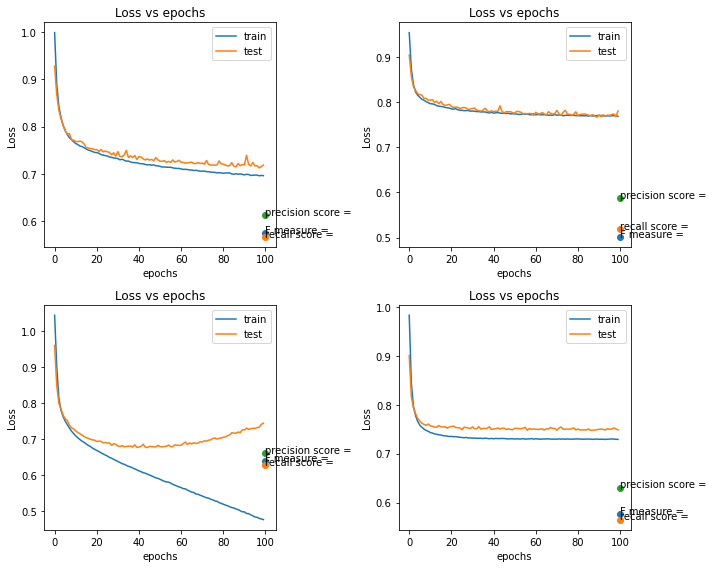

In [ ]:


#Initialize dataloader
# plt.subplot(2,2,1)
fig, ax = plt.subplots(2,2)
k=0
for embd,(traindata,testdata) in  enumerate(zip([w2v_traindata,glv_traindata],[w2v_testdata,glv_testdata])):#pick word embedding
  to_device(traindata,device)
  to_device(testdata,device)
  trainset = torch.utils.data.TensorDataset(traindata, trainlabel)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)#here we shuffle the dataset so the neural network doesnt optimise itself for a specific portion of the dataset(earlier or later) so in each execution the 64 tweets will be different
  testset = torch.utils.data.TensorDataset(testdata, testlabel)#this way we ensure a result isn't dependant on the luck of the order of the tweets
  testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
  trainloader = DeviceDataLoader(trainloader, device)#move data loader and their contents to your preffered device
  testloader = DeviceDataLoader(testloader, device)
  D_in = traindata.shape[1]
  print(D_in)
  H1 = 128#hyperparameters
  H2 = 64
  H3 = 32
  D_out = 3

  #Define Hyperparameters
  learning_rate = 1e-4
  #Initialize model, loss, optimizer
  for i , model in enumerate([Net(D_in, H1, H2, H3, D_out),Net2(D_in, H1, H2, H3, D_out)]):
    to_device(model,device)
    for j, (loss_func,optimizer) in enumerate(zip([F.cross_entropy],[torch.optim.Adam(model.parameters(), lr=learning_rate)])):#picks a loss and optimiser i use different ones later for to avoid making this convoluted
      train_losses=[]
      test_losses=[]
      final_output=[]
      final_ypred = []
      final_label= []
      for epoch in range(100):
        model.train()#train mode allows for gradient and hyper parameter optimisation.torch.optim takes model.parameters() so it can know which parameters to tweak and which not
        batch_losses = []
        for x_batch, y_batch in trainloader:
          output = model(x_batch)
          pred_probab = nn.Softmax(dim=1)(output)#activation function
          y_pred = pred_probab.argmax(1)
          loss = loss_func(output, y_batch) #models always output a one hot vector while y_batch is class number i.e 0 1 2
          batch_losses.append(loss.item())
          
          #Delete previously stored gradients
          optimizer.zero_grad()
          #Perform backpropagation starting from the loss calculated in this epoch
          loss.backward()
          #Update model's weights based on the gradients calculated during backprop
          optimizer.step()
        
        # print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(trainloader):.5f}")
        train_losses.append(sum(batch_losses)/len(trainloader))
        model.eval()#this eval/test mode will stop the model from training itself for the test dataset by locking down the model parameters and not doing backward probagation
        # scores=[]
        batch_losses = []
        for x_batch, y_batch in testloader:
          output = model(x_batch)
          pred_probab = nn.Softmax(dim=1)(output)
          y_pred = pred_probab.argmax(1)
          if epoch==99:#for the final epoch combine the results and store them(the final epoch will have the best results)
            final_output += output
            final_ypred += y_pred
            final_label += y_batch
          loss = loss_func(output, y_batch)
          batch_losses.append(loss.item())
        test_losses.append(sum(batch_losses)/len(testloader))
      k=k+1
      for metric,metric_name in zip([f1_score(torch.tensor(final_label),torch.tensor(final_ypred),average='macro' ),recall_score (torch.tensor(final_label),torch.tensor(final_ypred),average='macro' ) ,precision_score(torch.tensor(final_label),torch.tensor(final_ypred),average='macro' )], ["F measure =","recall score =","precision score ="]):
        ax[embd][i].scatter([100], [metric])
        ax[embd][i].annotate(metric_name, (100, metric))
      ax[embd][i].plot(range(100), train_losses)
      ax[embd][i].plot(range(100), test_losses)
      ax[embd][i].legend(['train', 'test'])
      ax[embd][i].set_xlabel("epochs")
      ax[embd][i].set_ylabel("Loss")
      ax[embd][i].title.set_text("Loss vs epochs")#plot loss vs epochs graph and point the prediction accuracy scores
fig.set_figwidth(10)
fig.set_figheight(4*2)
plt.tight_layout()
plt.show()

# Το καλύτερο μου μοντέλο
εδω χρησιμοποιω το Net3 που λιγο πιο φορτωμένο με MSE_LOSS function kai SGD optimiser. loss functions εκτος του cross entropy & MSE_LOSS εκαναν το μοντέλο να εχει απαίσα ακρίβεια προβλέψεων το ιδιο και η αλλαγη optimiser. ετρεξα με  nll_loss HingeEmbeddingLoss LBFGS  SGD. Άλλαξα την activation function σε SIGMOID και τώρα έβαλα 2 Hidden layers με μικρότερο αριθμό units. δεν χειροτέρευσε την ακρίβεια

#ΠΑΡΑΔΟΧΗ
αυτο το κελι δε θα τρέξει σε τοπικό υπολογιστη,τουλαχιστον όχι στον δικό μου.Τρέχτε το μονο στο colab. Δυστυχως δεν βρήκα κανένα τρόπο να κανω την mseloss να μεταλγωτιστεί, υποψιάζομαι λογω Python version. αν δεν τρέξετε αυτο το κελι τα παρακάτω θα τρέξουν με τα αποτελέσματα του πάνω κελιου με net1,2 cross entropy και adam

100
200


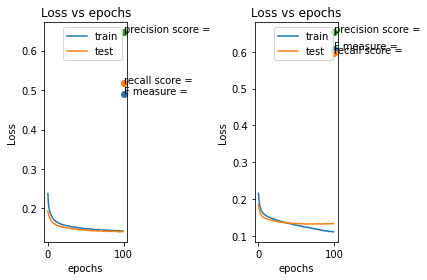

In [ ]:
k=0
for embd,(traindata,testdata) in  enumerate(zip([w2v_traindata,glv_traindata],[w2v_testdata,glv_testdata])):
  trainset = torch.utils.data.TensorDataset(traindata, trainlabel)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
  testset = torch.utils.data.TensorDataset(testdata, testlabel)
  testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
  D_in = traindata.shape[1]
  print(D_in)
  H1 = 120
  H2 = 50#changed the number of hidden layers and the number of their units
  D_out = 3
  #Define Hyperparameters
  learning_rate = 1e-4
  #Initialize model, loss, optimizer
  for i , model in enumerate([Net3(D_in, H1, H2, D_out)]):
    for j, (loss_func,optimizer) in enumerate(zip([F.mse_loss ],[torch.optim.RMSprop(model.parameters(), lr=learning_rate)])):
      train_losses=[]
      test_losses=[]
      final_output=[]
      final_ypred = []
      final_label= []
      for epoch in range(100):
        batch_losses = []
        model.train()
        for x_batch, y_batch in trainloader:
          output = model(x_batch)
          pred_probab = nn.Sigmoid()(output)
          y_pred = pred_probab.argmax(1)
          loss = loss_func(output.float(), torch.tensor(label_binarize(y_batch, classes=[0, 1, 2])).float())
          batch_losses.append(loss.item())
          
          #Delete previously stored gradients
          optimizer.zero_grad()
          #Perform backpropagation starting from the loss calculated in this epoch
          loss.backward()
          #Update model's weights based on the gradients calculated during backprop
          optimizer.step()
        
        # print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(trainloader):.5f}")
        train_losses.append(sum(batch_losses)/len(trainloader))
        model.eval()
        # scores=[]
        batch_losses = []
        for x_batch, y_batch in testloader:
          output = model(x_batch)
          # print(x_batch.shape[0])
          # print(y_batch)
          pred_probab = nn.Sigmoid()(output)##changed activation function
          y_pred = pred_probab.argmax(1)
          if epoch==99:
            final_output += output
            final_ypred += y_pred
            final_label += y_batch
          loss = loss_func(output.float(),torch.tensor(label_binarize(y_batch, classes=[0, 1, 2])).float())
          batch_losses.append(loss.item())
        test_losses.append(sum(batch_losses)/len(testloader))
      confusion_matrix(final_label,final_ypred)
      k=k+1
      plt.subplot(1, 2, k)
      for metric,metric_name in zip([f1_score(torch.tensor(final_label),torch.tensor(final_ypred),average='macro' ),recall_score (torch.tensor(final_label),torch.tensor(final_ypred),average='macro' ) ,precision_score(torch.tensor(final_label),torch.tensor(final_ypred),average='macro' )], ["F measure =","recall score =","precision score ="]):
        plt.scatter([100], [metric])
        plt.annotate(metric_name, (100, metric))
      plt.plot(range(100), train_losses)
      plt.plot(range(100), test_losses)
      plt.legend(['train', 'test'])
      plt.xlabel("epochs")
      plt.ylabel("Loss")
      plt.title("Loss vs epochs")
# figure. set_figswidth(10)
# figure.set_figheight(4*2)
plt.tight_layout()
plt.show()

αυτο δειχνει για το GloV embedding σε net3 αφου ηταν η τελευταια εκτελεση

In [ ]:
#make data compatible with roc_curve function
f =[o.tolist() for o in final_output]
f
fn = np.array(f)
fn

array([[0.78387153, 0.05677056, 0.15458657],
       [0.93916595, 0.04919791, 0.01838425],
       [0.95754254, 0.02026488, 0.02429202],
       ...,
       [0.1700906 , 0.12816623, 0.70040381],
       [0.04485992, 0.10415281, 0.84977782],
       [0.49797651, 0.39618403, 0.10388252]])

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
y_test=label_binarize(final_label, classes=[0, 1, 2])# roc curve function requires one-hot vectors
y_score=fn
n_classes=D_out
for i in range(n_classes):
    print(y_test[:, i])#oi ploiades poy einai pragmati tis classis i exoyn 1/true
    print(y_score[:, i])#oi ploiades poy NOMIZOYN oti einai tis classis i exoyn 1/true
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

[1 1 1 ... 0 0 0]
[0.78387153 0.93916595 0.95754254 ... 0.1700906  0.04485992 0.49797651]
[0 0 0 ... 0 0 1]
[0.05677056 0.04919791 0.02026488 ... 0.12816623 0.10415281 0.39618403]
[0 0 0 ... 1 1 0]
[0.15458657 0.01838425 0.02429202 ... 0.70040381 0.84977782 0.10388252]


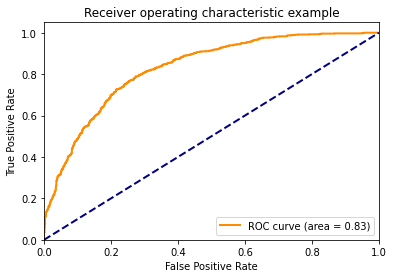

In [ ]:
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


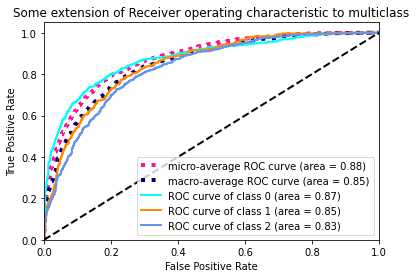

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

Τo anti-vax συνεχίζει να είναι η αδυναμία των μοντέλων μου οπως στην ασκηση 1 λόγω μικρου sample(15% του ολικου dataset)

In [ ]:
print(classification_report(final_label, final_ypred, digits=3,target_names=['neutral(0)','anti-vax(1)','pro-vax(2)']))

              precision    recall  f1-score   support

  neutral(0)      0.773     0.801     0.787      1065
 anti-vax(1)      0.561     0.297     0.389       296
  pro-vax(2)      0.670     0.743     0.704       921

    accuracy                          0.712      2282
   macro avg      0.668     0.614     0.626      2282
weighted avg      0.704     0.712     0.702      2282



#Συμπερασματα

Τα μοντελα έχουν φθίνουσα πορεία(με εξαιρεση μερικά του GloVE) με μεγάλη κυρτότητα στην αρχη που σημαίνει πως ο optimiser και η loss function μου με κινουν γρήγορα μακριά απο κακές αποφάσεις. με την ίδια εξαίρεση εφόσον η καμπυλες του train και test loss ακολουθούν σχεδόν ίδια πορεία πιστεύω δεν εχω Over η underfitting

το ROC curve μου ειναι αρκέτα ικανοποιητικό με το βέλτιστο σημειο των άλλων 2 κλάσσεων ειναι στο ~0.2-0.3 false positive rate γιατι αρχίζει το  true positive rate να εχει φθίνουσα βελτίωση. θέλουμε ενα roc curve να καμπυλώνει αποτομα προς τα πάνω αγκαλιάζοντας το αξονα y μακρια απο την μαύρη διαγωνιο που ενωνει την αρχή και το τέλος της

γενικά η ακρίβεια πρόβλεψης ειναι σχεδον ακριβώς ίση με αυτή της εργασίας 1 και νευρωνικών της sklearn οπως [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) .((πειραματιστηκα με αυτο γιατί έκανα στην αρχή το λαθος να νομίζω οτι παλι sklearn μοντέλα απαιτουσε η εργασια)). Αυτο το θεωρώ επιτυχία γιατί αυτά τα μοντέλα είναι Pre-trained προϊοντα μαζικής χρήσης αν και ομολογουμένως πολυ γενικευμένα για αυτον ακριβώς τον λογο

Υ.Γ δοκίμασα επίσης να αυξήσω το batch_size γιατι το 64 θεωρείται μικρό και κατάφερε να κάνει την καμπύλη του πρώτου συνδλυασμού με GloVe λιγότερο ανοδική.Πιστεύω έκανε καλύτερο generalisation 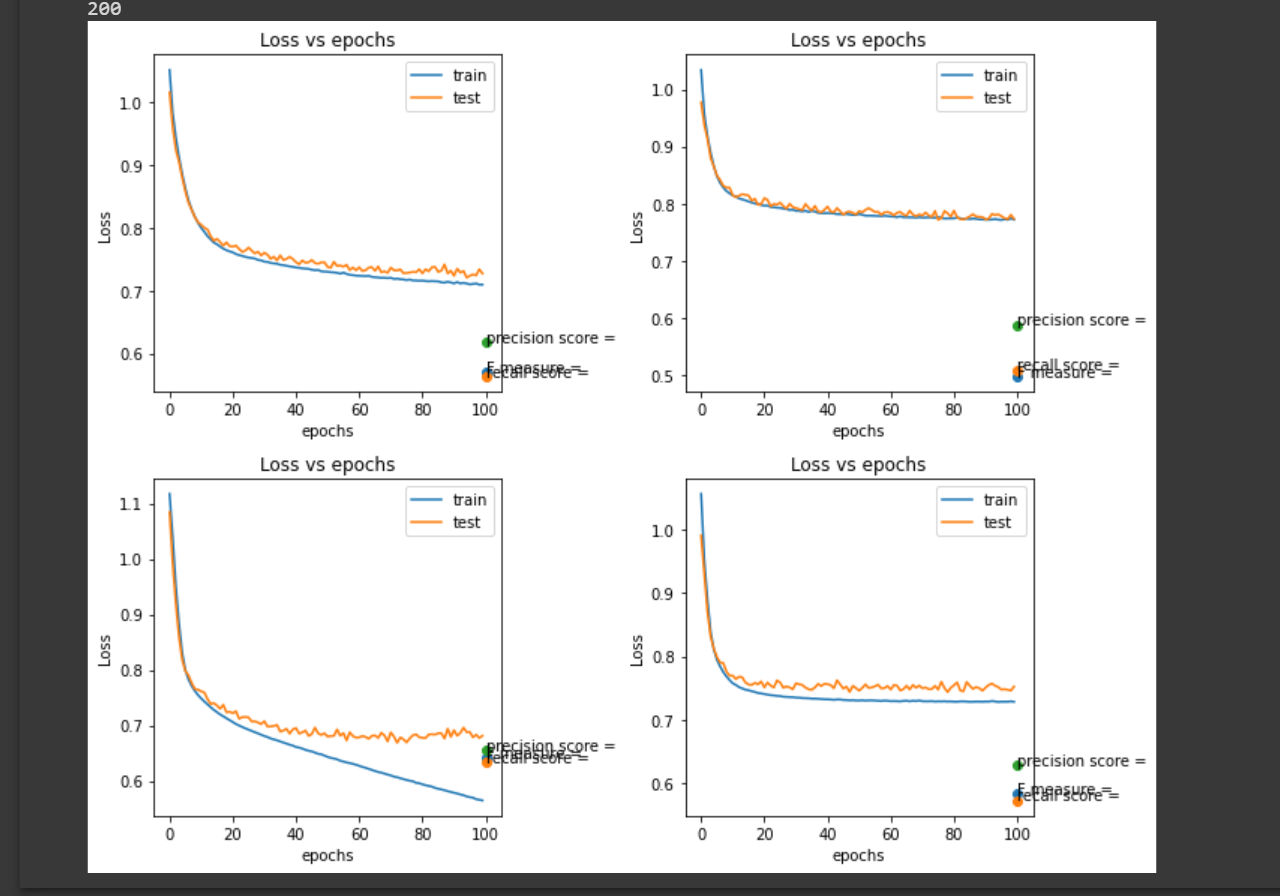